In [ ]:
#0.95% accuracy with EfficientNet

In [1]:
#!pip install efficientnet

In [2]:
#!pip install seaborn

In [3]:
#pip install opencv-python

In [4]:
#pip install tensorflow

In [5]:
#!pip install efficientnet

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2 
import os
import random

# Set the device
#device = "mps" if torch.backends.mps.is_available() else "cpu"
# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
#print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")

In [7]:
def load_dataset(path_dataset, target_size=(125, 125)): 
    dataset = []
    labels = []

    # Iterate over all folders in dataset_path
    for class_name in os.listdir(path_dataset):
        class_path = os.path.join(path_dataset, class_name)

        # check if the directory exists
        if os.path.isdir(class_path):
            # Iterate over all images in folder/class
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)

                # Skip non-image files
                if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue

                # Load image with OpenCV
                image = cv2.imread(image_path)

                # Check if the image was loaded successfully
                if image is not None:
                    # Resize the image
                    image = cv2.resize(image, target_size)

                    # Add image and label to dataset
                    dataset.append(image)
                    labels.append(class_name)

                else:
                    print(f"Error loading image: {image_path}")

    return np.array(dataset), np.array(labels)

# Usage
dataset_path = '/Users/peternoble/Downloads/Sugarcane_true/training'
dataset, labels = load_dataset(dataset_path)


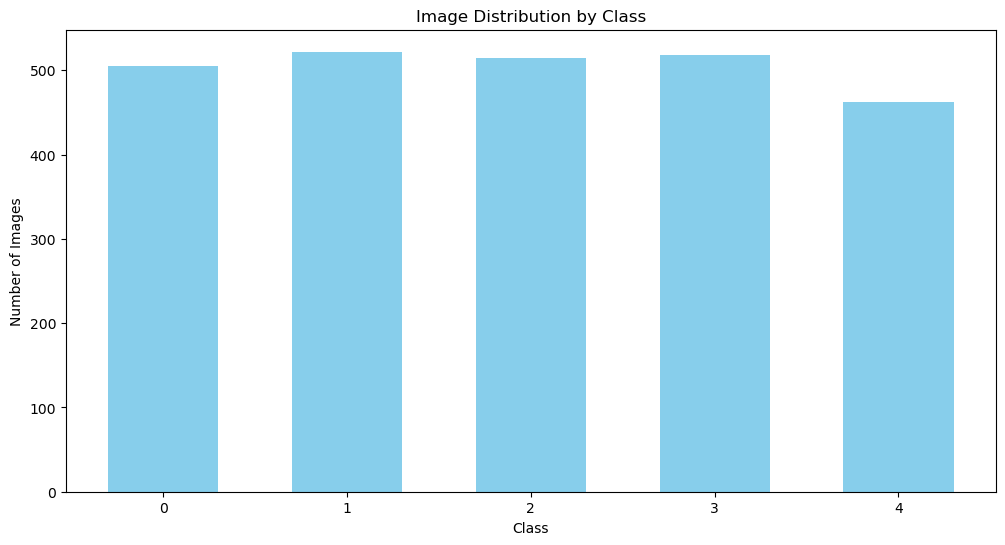

In [8]:
unique_labels, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

fig, ax = plt.subplots(figsize=(12, 6)) 
bars = ax.bar(class_counts.keys(), class_counts.values(), color='skyblue', width=0.6)  

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Image Distribution by Class')

plt.show()

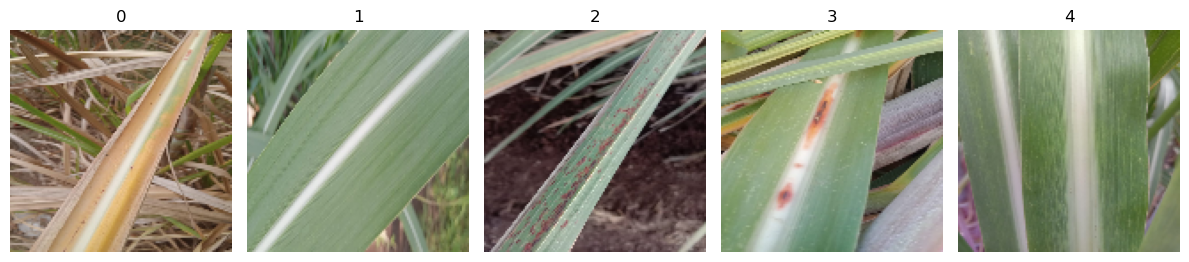

In [9]:
def show_samples(dataset, labels, classes, num_samples):
    plt.figure(figsize=(12, 6))
    
    for i, class_name in enumerate(classes[:num_samples]):  # Show only the first num_samples classes
        indices_class = np.where(labels == class_name)[0]
        sample_index = random.choice(indices_class)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(dataset[sample_index], cv2.COLOR_BGR2RGB))
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


unique_classes = np.unique(labels)
show_samples(dataset, labels, unique_classes, num_samples=5)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels into numbers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(dataset, encoded_labels, test_size=0.3, random_state=42)


def preprocess_image(image):
    #resized_image = cv2.resize(image, (125, 125))
    resized_image = cv2.resize(image, (244, 244))
    
    #Normalize values between 0 and 1
    normalized_image = resized_image / 255.0
    return normalized_image

# Apply preprocessing to training and testing sets
X_train = np.array([preprocess_image(image) for image in X_train])
X_test = np.array([preprocess_image(image) for image in X_test])

# Check the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (1764, 244, 244, 3)
Shape of X_test: (757, 244, 244, 3)
Shape of y_train: (1764,)
Shape of y_test: (757,)


In [11]:
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers.legacy import RMSprop  # Import RMSprop from the legacy module
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf

# Replace the line where you define the optimizer
custom_optimizer = RMSprop(learning_rate=0.001)

num_classes = len(np.unique(labels))

model = models.Sequential()

#efficientnet_model = EfficientNetB0(input_shape=(125, 125, 3), include_top=False, weights='imagenet', pooling='max')
efficientnet_model = EfficientNetB0(input_shape=(244, 244, 3), include_top=False, weights='imagenet', pooling='max')

model.add(efficientnet_model)

model.add(Dense(128, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(64, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(32, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(units=num_classes, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/150
56/56 [==============================] - 69s 1s/step - loss: 3.2664 - accuracy: 0.3532 - val_loss: 2.1670 - val_accuracy: 0.2470
Epoch 2/150
56/56 [==============================] - 65s 1s/step - loss: 1.4867 - accuracy: 0.6434 - val_loss: 2.1088 - val_accuracy: 0.3910
Epoch 3/150
56/56 [==============================] - 66s 1s/step - loss: 1.0277 - accuracy: 0.8254 - val_loss: 2.0904 - val_accuracy: 0.5495
Epoch 4/150
56/56 [==============================] - 64s 1s/step - loss: 0.8857 - accuracy: 0.8594 - val_loss: 2.3774 - val_accuracy: 0.4901
Epoch 5/150
56/56 [==============================] - 63s 1s/step - loss: 0.6641 - accuracy: 0.9184 - val_loss: 2.6728 - val_accuracy: 0.4293
Epoch 6/150
56/56 [==============================] - 63s 1s/step - loss: 0.6030 - accuracy: 0.9229 - val_loss: 1.6460 - val_accuracy: 0.6869
Epoch 7/150
56/56 [==============================] - 63s 1s/step - loss: 0.4837 - accuracy: 0.9439 - val_loss: 1.2236 - val_accuracy: 0.7583
Epoch 8/150
5

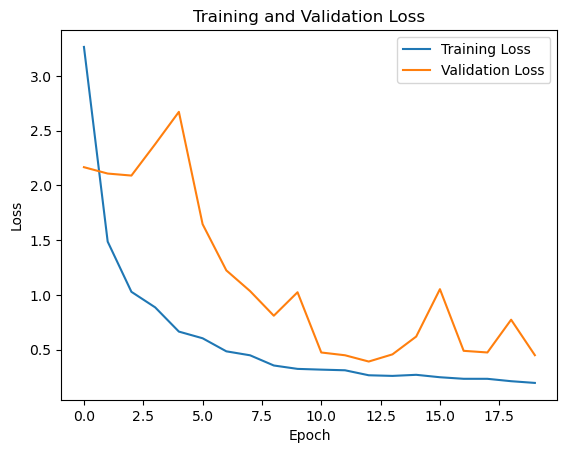

In [12]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

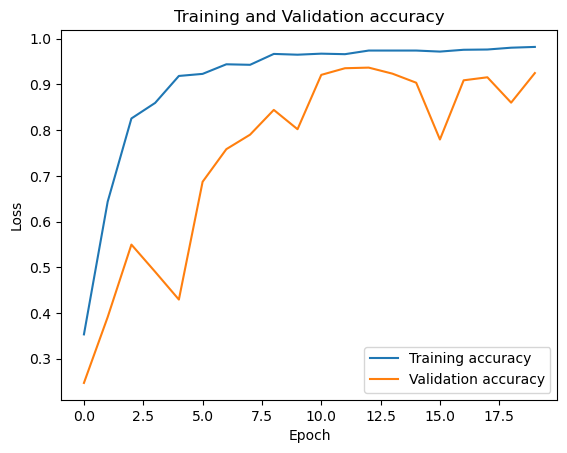

In [13]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


24/24 [==============================] - 6s 237ms/step


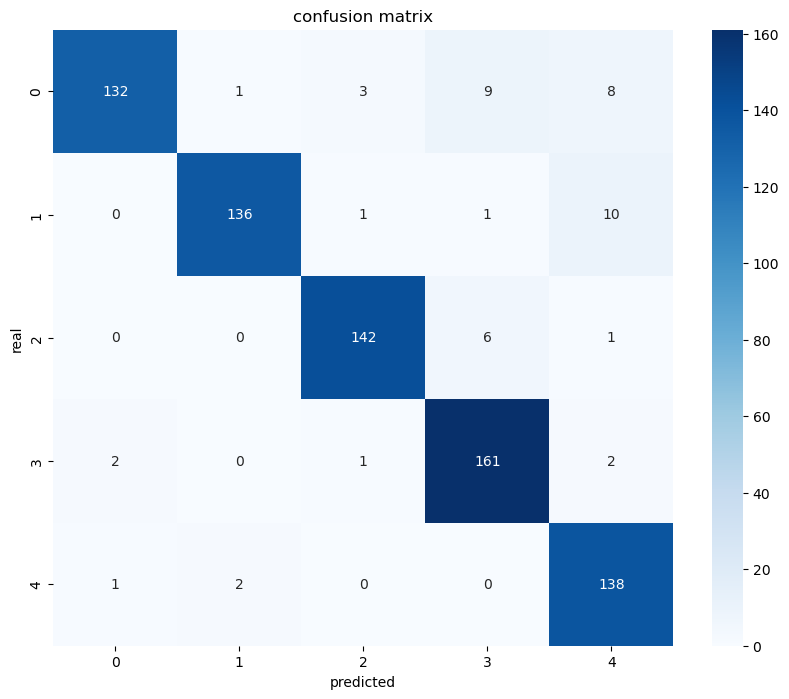

              precision    recall  f1-score   support

           0       0.98      0.86      0.92       153
           1       0.98      0.92      0.95       148
           2       0.97      0.95      0.96       149
           3       0.91      0.97      0.94       166
           4       0.87      0.98      0.92       141

    accuracy                           0.94       757
   macro avg       0.94      0.94      0.94       757
weighted avg       0.94      0.94      0.94       757



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = y_test

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('real')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

In [15]:
import tensorflow as tf
from efficientnet.tfkeras import EfficientNetB0

# Create or load your EfficientNet model in TensorFlow
tf_model = EfficientNetB0(weights='imagenet')

# Save only the model weights and biases
tf_model.save_weights('efficientnet_weights.h5')


In [16]:
def evaluate_model(loader, custom_labels, dataset_name):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            try:
                inputs = inputs.view(inputs.size(0), 3, 488, 488)  # Ensure the input size is correct
                outputs = model(inputs)
                predictions = torch.argmax(outputs, dim=1)
                all_predictions.extend(predictions.tolist())
                all_labels.extend(labels.tolist())  # Populate the true labels
            except Exception as e:
                print(f"An error occurred: {e}")

    # Compute accuracy for the dataset
    if len(all_labels) > 0:
        accuracy = sum(p == l for p, l in zip(all_predictions, all_labels)) / len(all_labels)
        print(f"{dataset_name} Accuracy: {accuracy:.1%}")
    else:
        print(f"No labels available for computing {dataset_name} accuracy.")

    # Analyze classification breakdown for the dataset
    for class_label, custom_label in enumerate(custom_labels):
        correct = sum(p == class_label and l == class_label for p, l in zip(all_predictions, all_labels))
        total_in_set = all_labels.count(class_label)

        if total_in_set == 0:
            print(f"{custom_label}: No examples in the {dataset_name} set")
        else:
            percentage = correct / total_in_set if total_in_set != 0 else 0.0
            print(f"{custom_label}: Correctly classified {correct}/{total_in_set} ({percentage:.1%})")

    # Return the lists of all_labels and all_predictions
    return all_labels, all_predictions


# Define custom labels
custom_labels = ['Yellow', 'Healthy', 'Rust', 'RedRot', 'Mosaic']

# Evaluate on the validation set
all_labels_val, all_predictions_val = evaluate_model(val_loader, custom_labels, "Validation")

# Evaluate on the test set
all_labels_test, all_predictions_test = evaluate_model(test_loader, custom_labels, "\nTest")

# Compute confusion matrix for the test set
conf_matrix = confusion_matrix(all_labels_test, all_predictions_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=custom_labels, yticklabels=custom_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Generate and print classification report
class_report = classification_report(all_labels_test, all_predictions_test, target_names=custom_labels)
print("Classification Report - Test Set:\n", class_report)


NameError: name 'val_loader' is not defined